In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)


plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
# Load prepared data
base_path = os.path.join('data', '3_train_and_test')

Xt = pickle.load(open(os.path.join(base_path, 'Xt.pickle'), 'rb'))
yt = pickle.load(open(os.path.join(base_path, 'yt.pickle'), 'rb'))
Xtt = pickle.load(open(os.path.join(base_path, 'Xtt.pickle'), 'rb'))
ytt = pickle.load(open(os.path.join(base_path, 'ytt.pickle'), 'rb'))

### Implementing the model

In [3]:
# copute logistic regression
logit_mod = sm.Logit(yt, Xt)
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.466163
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:          is subscriber   No. Observations:               438984
Model:                          Logit   Df Residuals:                   438931
Method:                           MLE   Df Model:                           52
Date:                Sun, 11 Sep 2022   Pseudo R-squ.:                  0.3275
Time:                        17:09:03   Log-Likelihood:            -2.0464e+05
converged:                       True   LL-Null:                   -3.0428e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -2.7847      0.067    -41.673      0.000      -2.

### Report Metrics

In [4]:
yhat_prob = logit_res.predict(Xtt)
yhat = np.round(yhat_prob).astype(int)

print(classification_report(ytt, yhat))

              precision    recall  f1-score   support

           0       0.14      0.79      0.23     55016
           1       0.99      0.78      0.87   1241599

    accuracy                           0.78   1296615
   macro avg       0.56      0.78      0.55   1296615
weighted avg       0.95      0.78      0.84   1296615



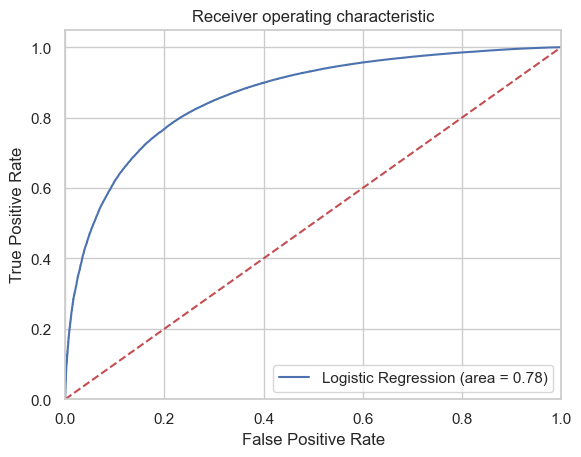

In [5]:
logit_roc_auc = roc_auc_score(ytt, yhat)
fpr, tpr, thresholds = roc_curve(ytt, yhat_prob)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Reminder on Precision, Recall and F1-Score

Copied from ([A Look at Precision, Recall, and F1-Score](https://towardsdatascience.com/a-look-at-precision-recall-and-f1-score-36b5fd0dd3ec)) 

**Accuracy**

$$ \frac{\text{number of correct predictions}}{\text{size of dataset}} = \frac{TP + TN}{TP + FP + TN + FN} $$

**Precision**: Share of correctly predicted Subscribers.

$$ \frac{\text{True Positives}}{\text{True Positives + False Positives}}$$

**Recall / Sensitivity**

$$ \frac{\text{True Positives}}{\text{True Positives + True Negatives}}$$

**Specificity**

$$ \frac{\text{True Negatives}}{\text{True Negatives + False Positives}} $$

**F1-Score**: Harmonic mean of Precision and Recall

$$ \frac{\text{Precision * Recall}}{\text{Precision + Recall}} $$